# EasyVisa Project

## Context:

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

## Objective:

In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. OFLC has hired your firm EasyVisa for data-driven solutions. You as a data scientist have to analyze the data provided and, with the help of a classification model:

* Facilitate the process of visa approvals.
* Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status. 


## Data Description

The data contains the different attributes of the employee and the employer. The detailed data dictionary is given below.

* case_id: ID of each visa application
* continent: Information of continent the employee
* education_of_employee: Information of education of the employee
* has_job_experience: Does the employee has any job experience? Y= Yes; N = No
* requires_job_training: Does the employee require any job training? Y = Yes; N = No 
* no_of_employees: Number of employees in the employer's company
* yr_of_estab: Year in which the employer's company was established
* region_of_employment: Information of foreign worker's intended region of employment in the US.
* prevailing_wage:  Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment. 
* unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
* full_time_position: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
* case_status:  Flag indicating if the Visa was certified or denied

## Importing necessary libraries and data

In [1]:
import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Library to split data
from sklearn.model_selection import train_test_split

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 100)


# Libraries different ensemble classifiers
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# Libraries to get different metric scores
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# To tune different models
from sklearn.model_selection import GridSearchCV

## Data Overview

- Observations
- Sanity checks

In [2]:
visa = pd.read_csv('EasyVisa.csv')

In [3]:
df = visa.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


Of the 11 variables, there are 3 numeric variables of which 2 are stored as ints and 1 is stored as a float (prevailing wage). The 8 non-numeric variables are all stored as object types.

In [5]:
df.shape

(25480, 12)

In [6]:
df.describe()

,no_of_employees,yr_of_estab,prevailing_wage
count,25480.000000,25480.000000,25480.000000
mean,5667.043210,1979.409929,74455.814592
std,22877.928848,42.366929,52815.942327
min,-26.000000,1800.000000,2.136700
25%,1022.000000,1976.000000,34015.480000
50%,2109.000000,1997.000000,70308.210000
75%,3504.000000,2005.000000,107735.512500
max,602069.000000,2016.000000,319210.270000


We can see some obvious issues with the dataset in this view, first being that the number of employees column has at least one negative entry, which intuitively doesn't make sense. Additionally, the prevailing wage column may cause us issues because there's also a unit column, so the minimum of 2 is very likely an hourly wage while at least 75% of the entries appear to be annual wages. We'll need to treat that later to make sure we can accurately compare these wages. Finally, the year of establishment is a temporal variable, so we'll want to update the variable type to make sure we don't treat it as a true numeric variable.

In [7]:
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [8]:
df.isna().sum()

case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

In [9]:
df.duplicated().sum()

0

The data set has no null values and no duplicate entries

In [10]:
df.nunique()

case_id                  25480
continent                    6
education_of_employee        4
has_job_experience           2
requires_job_training        2
no_of_employees           7105
yr_of_estab                199
region_of_employment         5
prevailing_wage          25454
unit_of_wage                 4
full_time_position           2
case_status                  2
dtype: int64

In [11]:
df.drop(columns = ['case_id'], inplace=True)

Dropping the case id column as it's simply an index variable and won't add to our analysis.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   continent              25480 non-null  object 
 1   education_of_employee  25480 non-null  object 
 2   has_job_experience     25480 non-null  object 
 3   requires_job_training  25480 non-null  object 
 4   no_of_employees        25480 non-null  int64  
 5   yr_of_estab            25480 non-null  int64  
 6   region_of_employment   25480 non-null  object 
 7   prevailing_wage        25480 non-null  float64
 8   unit_of_wage           25480 non-null  object 
 9   full_time_position     25480 non-null  object 
 10  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 2.1+ MB


## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

## Univariate Analysis

In [13]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [14]:
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Observations on Continent

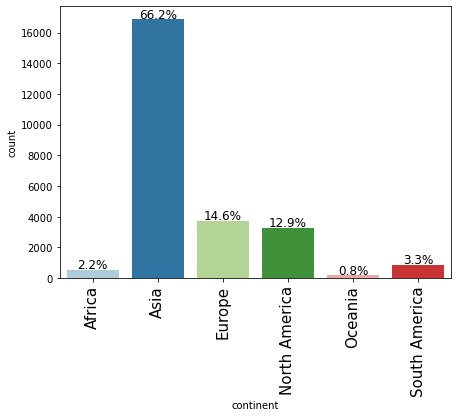

In [15]:
labeled_barplot(df, 'continent', perc=True)

The high plurality of entries are potential employees from Asia, making up nearly 2/3 of entries. There are also large contingents from Europe and North America, followed by much smaller groups from South America, Africa and Oceania.

### Observations on Education of Employee

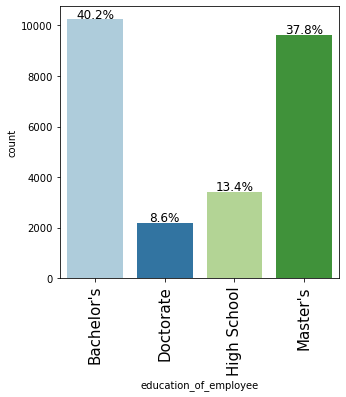

In [16]:
labeled_barplot(df, 'education_of_employee', perc=True)

Nearly 90% of applicants have completed some level of advanced education, with nearly 40% holding a master's degree and almost 10% having completed a doctorate. Based on outside knowledge, this appears to be a much more educated group on average than the US working population as a whole.

### Observations on Job Experience

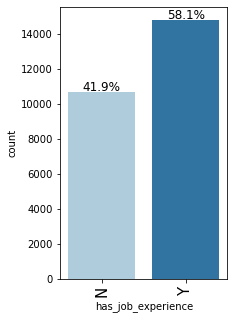

In [17]:
labeled_barplot(df, 'has_job_experience', perc=True)

While this group of applicants is highly educated, only about 60% have previous job experience which intuitively seems like it would be lower than the overall job market. It appears that many of the applicants have focused more on education than job experience, though the majority of applicants do have previous experience.

### Observations on Training Requirement

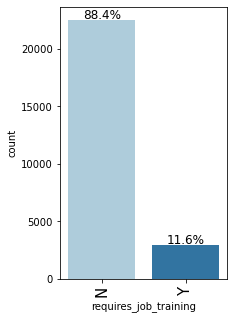

In [18]:
labeled_barplot(df, 'requires_job_training', perc=True)

Somewhat surprisingly, nearly 90% of applicants don't require job training for the position they're applying for, despite over 40% not having prior job experience. This is likely because of the high level of education that this group has.

### Observations on No. of Employees

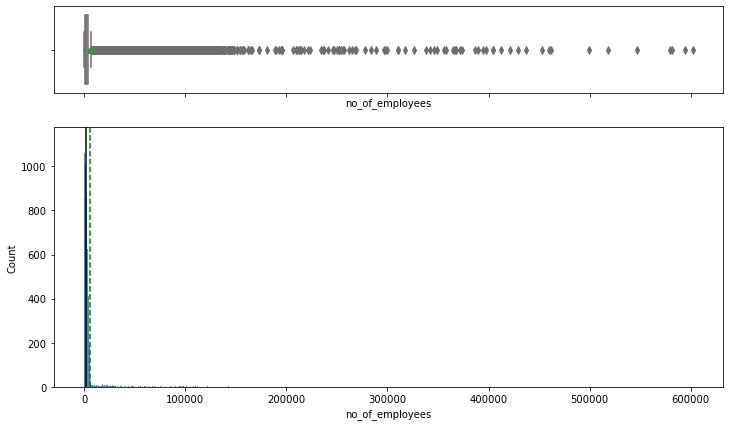

In [19]:
histogram_boxplot(df, 'no_of_employees')

This plot is difficult to interpret because there are a significant number of meaningful outliers which gives this distribution a large right skew. The majority of companies have a small number of employees, but there are some companies in the data set with over a half million employees.

In [20]:
df['no_of_employees'].describe()

count     25480.000000
mean       5667.043210
std       22877.928848
min         -26.000000
25%        1022.000000
50%        2109.000000
75%        3504.000000
max      602069.000000
Name: no_of_employees, dtype: float64

This distribution illustrates the large right skew on this variable, with the median of 2109 being less than half of the mean of 5667. The mean is in fact above the 3rd quartile, showing how strong the skew is on this distribution.

<AxesSubplot:xlabel='no_of_employees', ylabel='Count'>

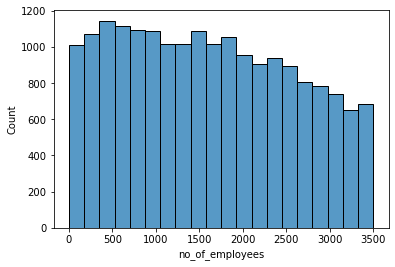

In [21]:
sns.histplot(data = df, x = 'no_of_employees', bins = 20, binrange = (0,3500))

This distribution with employees capped at the 75th percentile shows that even in the densest part of the distribution there's a slight right skew, with a fairly flat distribution from 0 to about 2000 (near our total mean), and then we see decreasing counts in each bin from there.

### Observations on Year of Establishment

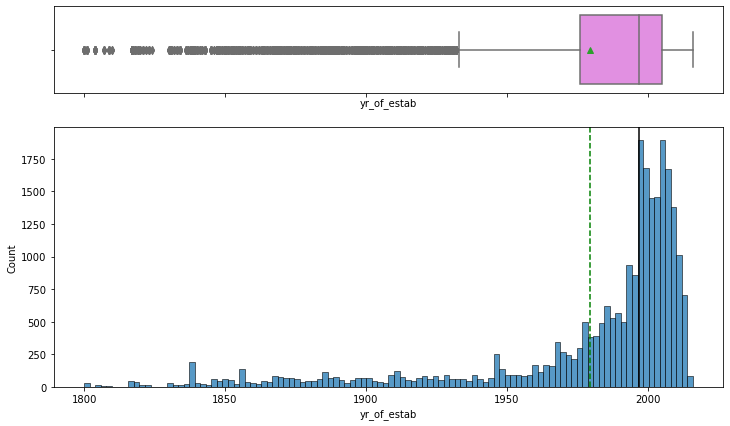

In [22]:
histogram_boxplot(df, 'yr_of_estab')

In [23]:
df['yr_of_estab'].describe()

count    25480.000000
mean      1979.409929
std         42.366929
min       1800.000000
25%       1976.000000
50%       1997.000000
75%       2005.000000
max       2016.000000
Name: yr_of_estab, dtype: float64

There are companies founded as long ago as 1800 that are receiving applications in this dataset, giving the distribution a significant left skew. While the mean of the distribution is in 1979, the median company founding date is 1997, with one company founded as recently as 2016.

### Observations on Region

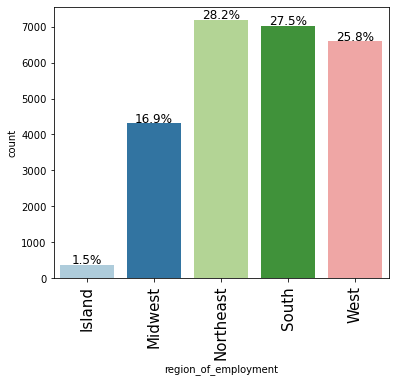

In [24]:
labeled_barplot(df, 'region_of_employment', perc=True)

The regions of potential employment are fairly evenly distributed with only "island" having a very small percentage. This presumably refers to Hawaii or Puerto Rico, while the other four regions are standard in describing US regions. While the midwest only makes up 17% of application regions, the South, West and Midwest are all between 25 and 28%.

### Observations on Prevailing Wage

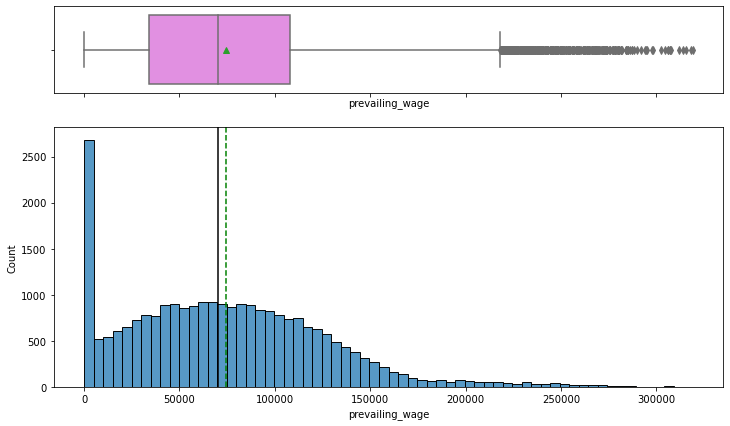

In [25]:
histogram_boxplot(df, 'prevailing_wage')

The prevailing wage is a very interesting distribution to look into. Off the bat, this is much closer to a normal distribution than the number of employees variable, though there's still a strong right skew to this distribution. However, there's also a large spike at the low end, which I'd hypothesize is made up mostly of entries where the wage unit is hourly. Because the unit of wage is so important to comparing these wages, I'll split this distribution into the different units to look at each individually.

In [26]:
df['unit_of_wage'].value_counts()

Year     22962
Hour      2157
Week       272
Month       89
Name: unit_of_wage, dtype: int64

In [27]:
df_hourly = df[(df['unit_of_wage'] == 'Hour')]

In [28]:
df_annual = df[(df['unit_of_wage'] == 'Year')]

In [29]:
df_monthly = df[(df['unit_of_wage'] == 'Month')]

In [30]:
df_weekly = df[(df['unit_of_wage'] == 'Week')]

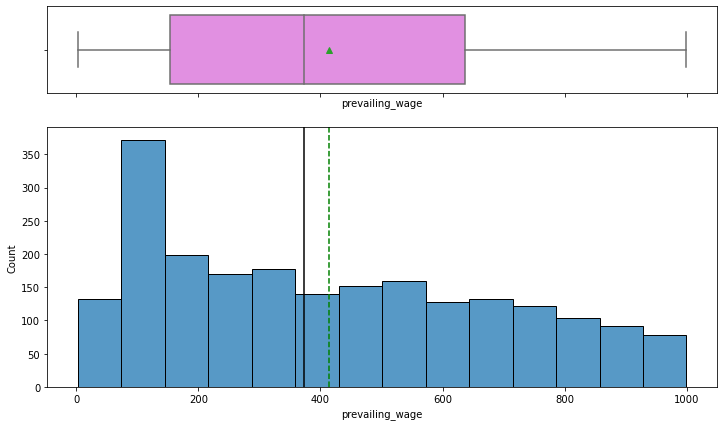

In [31]:
histogram_boxplot(df_hourly, 'prevailing_wage')

While this is a much more helpful view to separate hourly wages from annual, something still seems off here. The mean hourly wage of $400 would net out to $800,000 per year assuming 40 hours per week and 50 weeks worked per year. Unless there is an extremely high paying industry that lists its wages in hourly units (possibly lawyers?), this data seems to be flawed. One possibility could be that these wages are listed as hourly, but the approximate weekly total is entered as the prevailing wage. That would make the mean approx. $10/hour and the annual total closer to $20,000. While this is much more reasonable, that would make these significantly lower paying than the weekly, monthly and annual wages. I'll revisit this in the data treatment section.

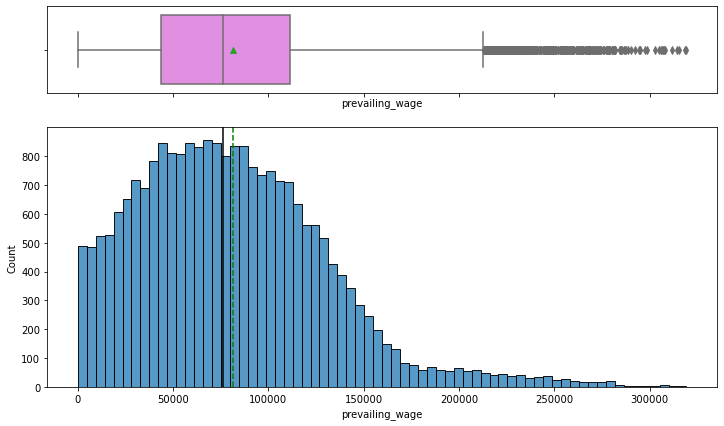

In [32]:
histogram_boxplot(df_annual, 'prevailing_wage')

After removing the hourly, weekly and monthly wages, our annual wage distribution (which makes up about 90% of entries) still looks to be relatively close to normal with a right skew. The mean is noticeably higher than the median, but not nearly to the extent of our other numeric variable, the number of employees. There are still a large number of outliers on the high end, meaning there are a good number of high paying jobs in this data set.

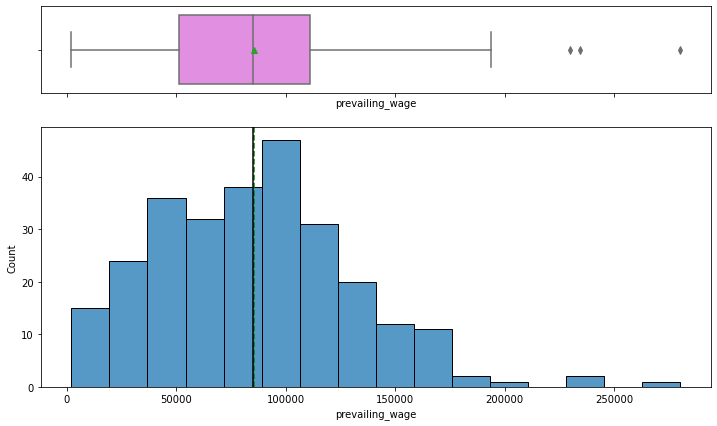

In [33]:
histogram_boxplot(df_weekly, 'prevailing_wage')

As with the hourly wages, something appears off with weekly wages. The distribution here is very similar to annual wages, leading me to the assumption that these are incorrectly entered and are marked as weekly wages but listed with the annual total.

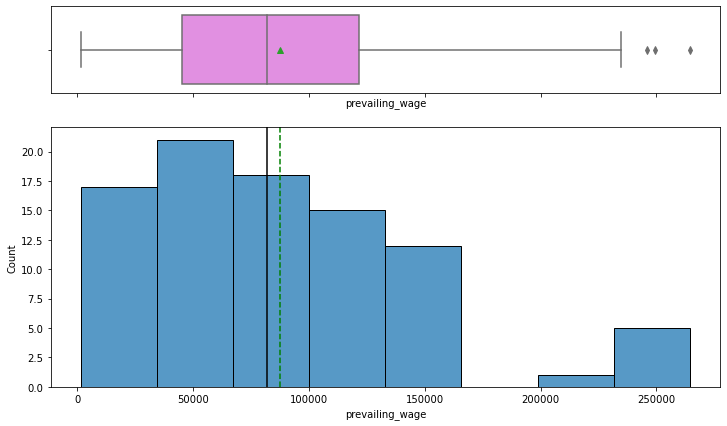

In [34]:
histogram_boxplot(df_monthly, 'prevailing_wage')

The same comment from hourly wages holds for monthly, increasing my confidence in my assumption that these are all annual wages except for those listed as hourly.

### Observations on Wage Unit

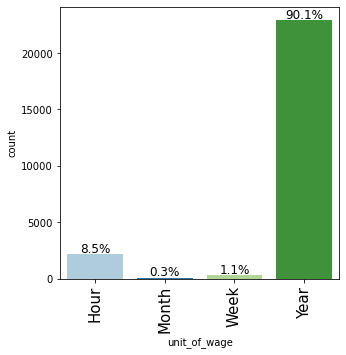

In [35]:
labeled_barplot(df, 'unit_of_wage', perc=True)

As noted in previous observations, over 90% of entries have annual wages and about 9% are hourly, with a very small number being listed as monthly or weekly.

### Observations on Full-Time/Part-Time

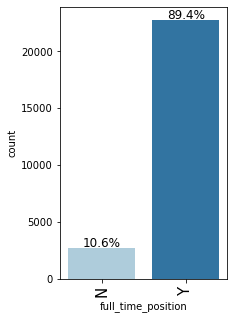

In [36]:
labeled_barplot(df, 'full_time_position', perc=True)

Nearly 90% of positions are listed as full time. Interestingly, this is very close to the percentage of jobs listed with annual salaries. My assumption is that these variables will be highly correlated with hourly wages tending to be part time and annual wages being correlated with full time positions. I'll confirm this in the bivariate analysis section.

### Observations on Case Status

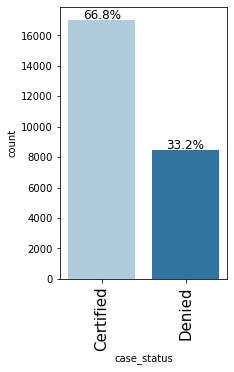

In [37]:
labeled_barplot(df, 'case_status', perc=True)

About 2/3 of applications are certified/approved, with the other third being denied.

## Bivariate Analysis

In [38]:
def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [39]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

**Leading Questions**:
1. Those with higher education may want to travel abroad for a well-paid job. Does education play a role in Visa certification? 

2. How does the visa status vary across different continents? 
 
3. Experienced professionals might look abroad for opportunities to improve their lifestyles and career development. Does work experience influence visa status? 
 
4. In the United States, employees are paid at different intervals. Which pay unit is most likely to be certified for a visa? 
 
5. The US government has established a prevailing wage to protect local talent and foreign workers. How does the visa status change with the prevailing wage?

### 1. Those with higher education may want to travel abroad for a well-paid job. Does education play a role in Visa certification? 

In [40]:
df["case_status"] = df["case_status"].apply(
    lambda x: 1 if x == "Certified" else 0
)

In [41]:
df['case_status'].value_counts()

1    17018
0     8462
Name: case_status, dtype: int64

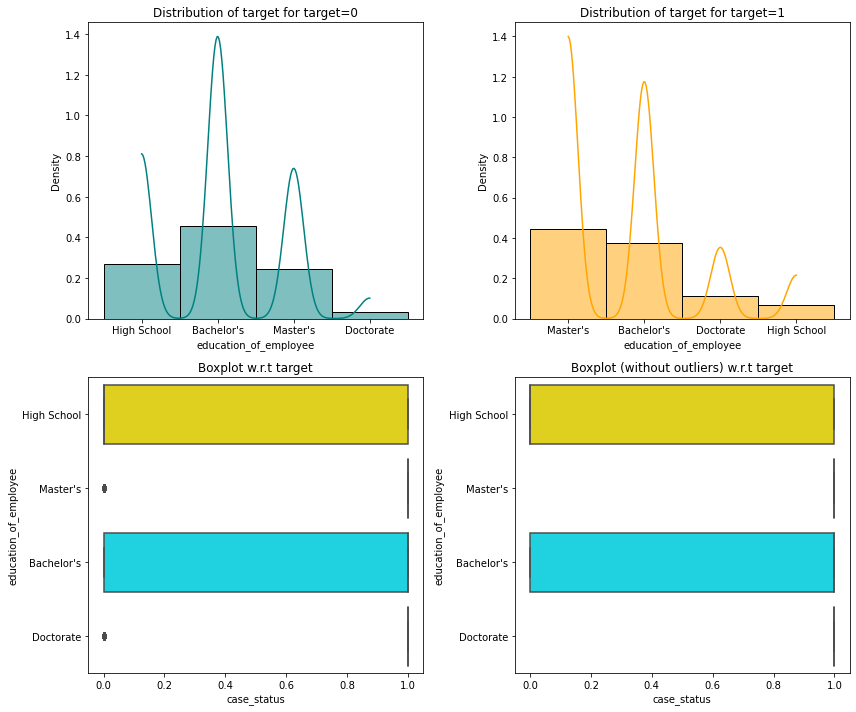

In [42]:
distribution_plot_wrt_target(df, 'education_of_employee', 'case_status')

case_status               0      1    All
education_of_employee                    
All                    8462  17018  25480
Bachelor's             3867   6367  10234
High School            2256   1164   3420
Master's               2059   7575   9634
Doctorate               280   1912   2192
------------------------------------------------------------------------------------------------------------------------


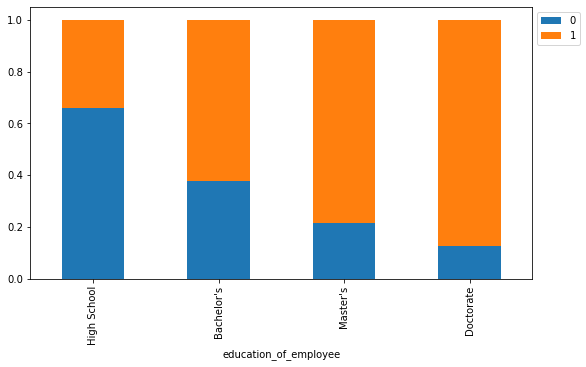

In [43]:
stacked_barplot(df, 'education_of_employee', 'case_status')

Education appears to play a very significant role in whether an application is approved or denied. While over 60% of applications with a high school education are denied, only about 20% of those with a doctorate are, and each additional level of education appears to be correlated with an increased chance of application approval.

### 2. How does the visa status vary across different continents? 

case_status       0      1    All
continent                        
All            8462  17018  25480
Asia           5849  11012  16861
North America  1255   2037   3292
Europe          775   2957   3732
South America   359    493    852
Africa          154    397    551
Oceania          70    122    192
------------------------------------------------------------------------------------------------------------------------


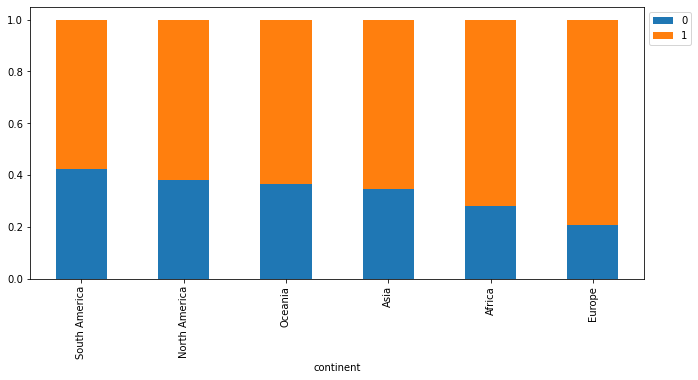

In [44]:
stacked_barplot(df, 'continent', 'case_status')

The distribution is fairly consistent across continents, with all falling between about 25% and 40% of applications being denied. Those from Europe and Africa are the most likely to be approved at 70+%, while those from North and South America are closer to 60% approval.

### 3. Experienced professionals might look abroad for opportunities to improve their lifestyles and career development. Does work experience influence visa status? 

case_status            0      1    All
has_job_experience                    
All                 8462  17018  25480
N                   4684   5994  10678
Y                   3778  11024  14802
------------------------------------------------------------------------------------------------------------------------


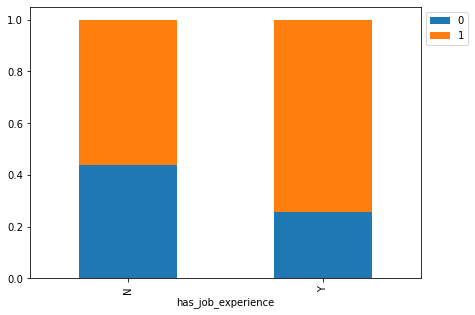

In [45]:
stacked_barplot(df, 'has_job_experience', 'case_status')

Having job experience definitely seems to improve ones chances of having their application approved. Those who report having job experience are approved about 75% of the time, while those without experience are closer to 60% approval.

### 4. In the United States, employees are paid at different intervals. Which pay unit is most likely to be certified for a visa? 

case_status      0      1    All
unit_of_wage                    
All           8462  17018  25480
Year          6915  16047  22962
Hour          1410    747   2157
Week           103    169    272
Month           34     55     89
------------------------------------------------------------------------------------------------------------------------


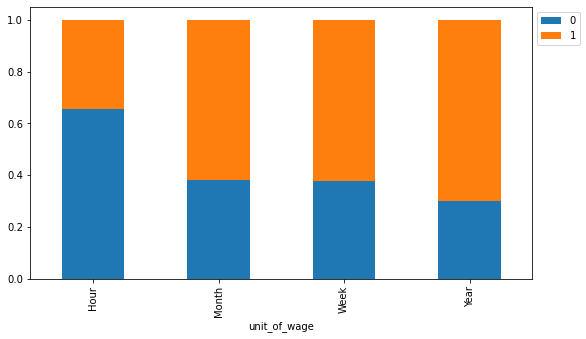

In [46]:
stacked_barplot(df, 'unit_of_wage', 'case_status')

Annual wages are the most likely to be certified at about 70%, and it makes sense that this is close to the overall average as these units make up 90% of the dataset. Hourly wages are far and away the least likely to be approved, with only about 35% of these applications getting approval despite an overall average of 67%.

### 5. The US government has established a prevailing wage to protect local talent and foreign workers. How does the visa status change with the prevailing wage?

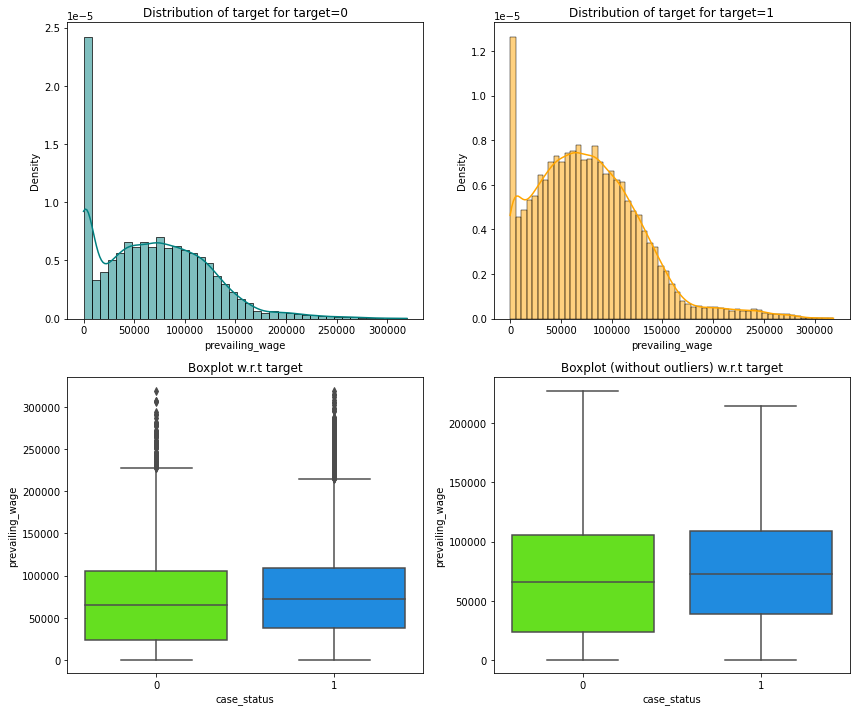

In [47]:
distribution_plot_wrt_target(df, 'prevailing_wage', 'case_status')

Prevailing wage does appear to influence case status, as approved cases tend to have a higher average prevailing wage than denied cases. The difference in median looks to be approx. $10,000.

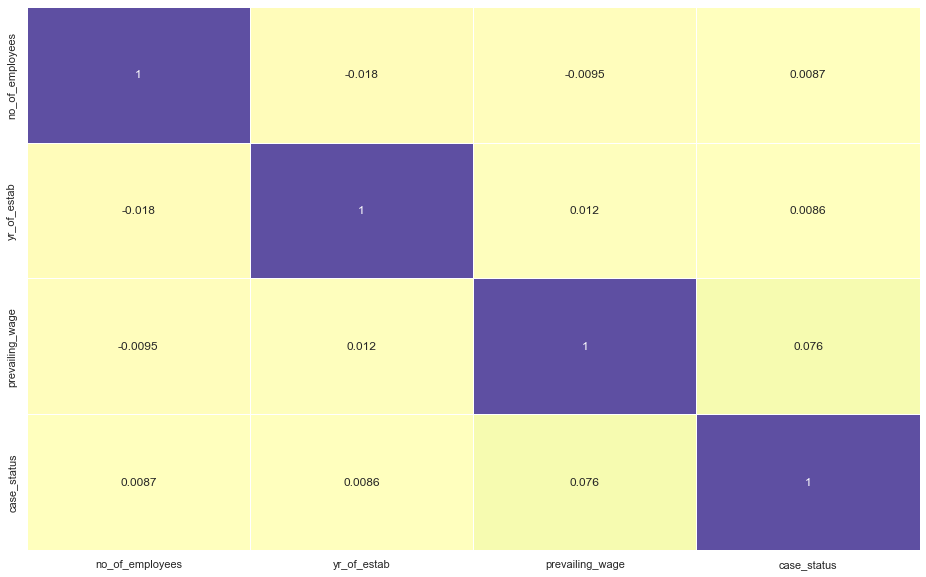

In [48]:
sns.set(rc={'figure.figsize':(16,10)})
sns.heatmap(df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="Spectral")
plt.show()

## Data Preprocessing

- Missing value treatment (if needed)
- Feature engineering 
- Outlier detection and treatment (if needed)
- Preparing data for modeling 
- Any other preprocessing steps (if needed)

There are no missing values, so we can skip that step. For feature engineering, I previously converted case status to a numeric 1 and 0 to better conduct EDA with case status as the target variable.

### Outlier Treatment

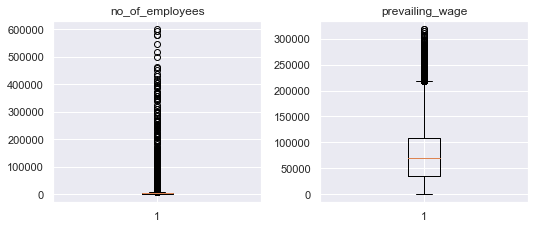

In [49]:
# outlier detection using boxplot
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
# dropping case_status as it's our dependent variable
# dropping yr_of_estab as it is a temporal variable
numeric_columns.remove("case_status")
numeric_columns.remove("yr_of_estab")

plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

Both of our quantitative columns have significant numbers of outliers. However, both have a similar issue in that all outliers are on the high side. For number of employees, the outliers are so significant that the max is about 20x the median. I am going to cap all of these outliers at the 1.5iqr+q3 whisker to keep the shape of the distribution intact while removing the significant skew from the high end outliers.

In [50]:
def treat_outliers(df, col):
    """
    Treats outliers in a variable
    df1: dataframe
    col: dataframe column
    """
    Q1 = df[col].quantile(0.25)  # 25th percentile
    Q3 = df[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # all the values smaller than Lower_Whisker will be assigned the value of Lower_Whisker
    # all the values greater than Upper_Whisker will be assigned the value of Upper_Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df

col_list = [
    "no_of_employees",
    "prevailing_wage"
]

def treat_outliers_all(df, col_list):
    for c in col_list:
        df = treat_outliers(df, c)

    return df

In [51]:
df1 = treat_outliers_all(df, col_list)

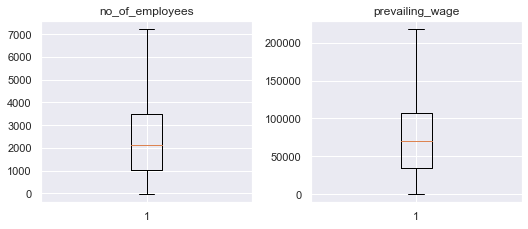

In [52]:
# outlier detection using boxplot
numeric_columns = df1.select_dtypes(include=np.number).columns.tolist()
# dropping case_status as it's our dependent variable
# dropping yr_of_estab as it is a temporal variable
numeric_columns.remove("case_status")
numeric_columns.remove("yr_of_estab")

plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(df1[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

In [53]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.0,2494.988932,1874.490855,-26.0000,1022.00,2109.00,3504.0000,7227.00000
yr_of_estab,25480.0,1979.409929,42.366929,1800.0000,1976.00,1997.00,2005.0000,2016.00000
prevailing_wage,25480.0,73961.381602,51229.260352,2.1367,34015.48,70308.21,107735.5125,218315.56125
case_status,25480.0,0.667896,0.470977,0.0000,0.00,1.00,1.0000,1.00000


I'm still confused by the no_of_employees variable having at least one negative value. I want to look into this and treat any negative values in that variable.

In [54]:
df1_low_employee = df1[(df1['no_of_employees'] < 10)]

In [55]:
df1_low_employee.describe()

,no_of_employees,yr_of_estab,prevailing_wage,case_status
count,33.000000,33.000000,33.000000,33.000000
mean,-17.757576,1991.303030,64842.333273,0.515152
std,6.285053,20.598066,47513.249244,0.507519
min,-26.000000,1923.000000,103.970000,0.000000
25%,-25.000000,1984.000000,27599.350000,0.000000
50%,-14.000000,1999.000000,58488.500000,1.000000
75%,-11.000000,2005.000000,100463.580000,1.000000
max,-11.000000,2014.000000,167851.800000,1.000000


There are 33 entries where a company has fewer than 10 employees, and all of these entries have negative values. My first assumption is that these entries were accidentally entered as negatives instead of positives, but because I can't be sure the safest thing is to remove these 33 entries from our data set.

In [56]:
df1 = df1[(df1['no_of_employees'] > 0)]

In [57]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25447.0,2498.247495,1873.519108,12.0000,1025.00,2112.0,3506.500,7227.00000
yr_of_estab,25447.0,1979.394506,42.385932,1800.0000,1976.00,1997.0,2005.000,2016.00000
prevailing_wage,25447.0,73973.207303,51233.716503,2.1367,34039.21,70312.5,107739.505,218315.56125
case_status,25447.0,0.668094,0.470907,0.0000,0.00,1.0,1.000,1.00000


We now have a count of 25447 vs the previous count of 25480, so it looks like we successfully cut out the 33 entries with negative numbers of employees.

In [58]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25447 entries, 0 to 25479
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   continent              25447 non-null  object 
 1   education_of_employee  25447 non-null  object 
 2   has_job_experience     25447 non-null  object 
 3   requires_job_training  25447 non-null  object 
 4   no_of_employees        25447 non-null  float64
 5   yr_of_estab            25447 non-null  int64  
 6   region_of_employment   25447 non-null  object 
 7   prevailing_wage        25447 non-null  float64
 8   unit_of_wage           25447 non-null  object 
 9   full_time_position     25447 non-null  object 
 10  case_status            25447 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 2.3+ MB


### Preparing Data for Modeling

In [59]:
# remove case status from x and create y to make case status the dependent variable
X = df1.drop('case_status', axis=1)
Y = df1["case_status"]

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25447 entries, 0 to 25479
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   continent              25447 non-null  object 
 1   education_of_employee  25447 non-null  object 
 2   has_job_experience     25447 non-null  object 
 3   requires_job_training  25447 non-null  object 
 4   no_of_employees        25447 non-null  float64
 5   yr_of_estab            25447 non-null  int64  
 6   region_of_employment   25447 non-null  object 
 7   prevailing_wage        25447 non-null  float64
 8   unit_of_wage           25447 non-null  object 
 9   full_time_position     25447 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.1+ MB


In [61]:
X = pd.get_dummies(X,
    columns=X.select_dtypes(include=["object", "category"]).columns.tolist(),
    drop_first=True) #creating dummy variables

In [62]:
X.head()

,no_of_employees,yr_of_estab,prevailing_wage,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,education_of_employee_Doctorate,education_of_employee_High School,education_of_employee_Master's,has_job_experience_Y,requires_job_training_Y,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,full_time_position_Y
0,7227.0,2007,592.2029,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
1,2412.0,2002,83425.6500,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1
2,7227.0,2008,122996.8600,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1
3,98.0,1897,83434.0300,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
4,1082.0,2005,149907.3900,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,1


## EDA

- It is a good idea to explore the data once again after manipulating it.

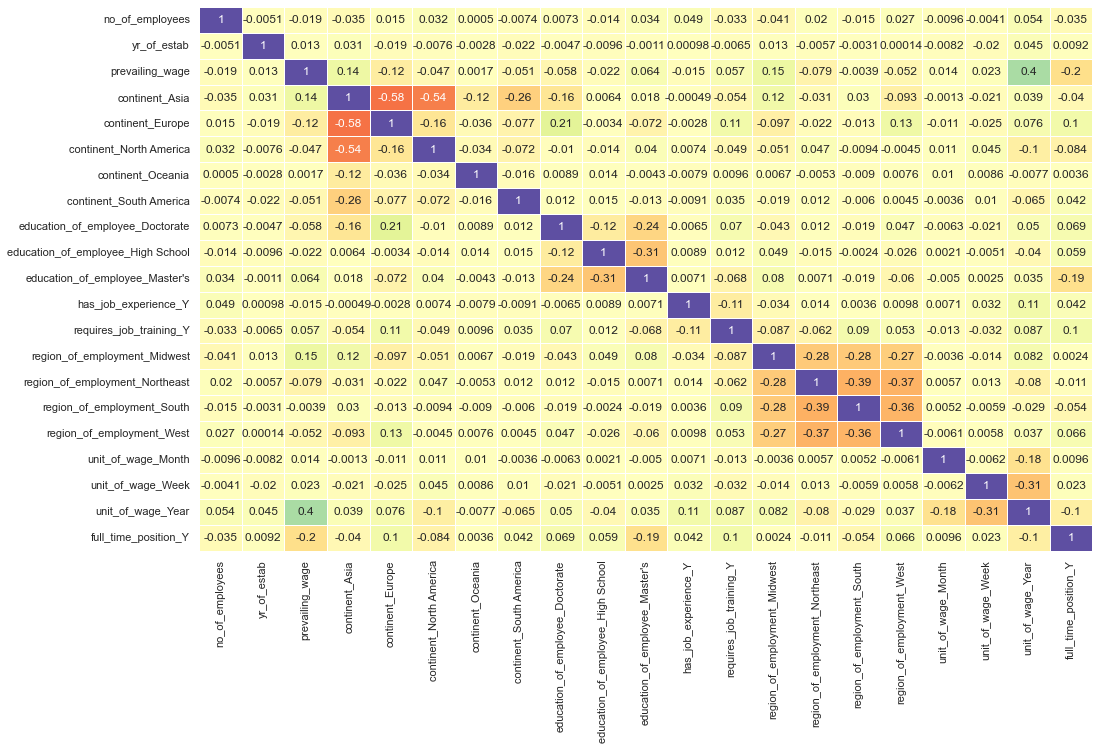

In [63]:
sns.set(rc={'figure.figsize':(16,10)})
sns.heatmap(X.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="Spectral")
plt.show()

## Building bagging and boosting models

In [64]:
# Splitting data into training and test set:
x_train, x_test, y_train, y_test =train_test_split(X, Y, test_size=0.3, random_state=1,stratify=Y)
print(x_train.shape, x_test.shape)

(17812, 21) (7635, 21)


In [65]:
print(y_train.value_counts(1))

1    0.668089
0    0.331911
Name: case_status, dtype: float64


In [66]:
print(y_test.value_counts(1))

1    0.668107
0    0.331893
Name: case_status, dtype: float64


In [67]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [68]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Decision Tree Model

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.665357  0.743972   0.752379  0.748152


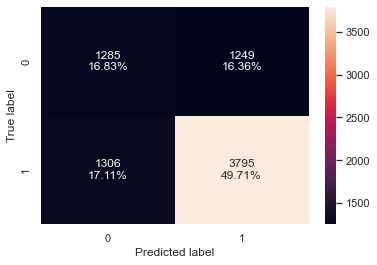

In [69]:
#Fitting the model
d_tree = DecisionTreeClassifier(random_state=1)
d_tree.fit(x_train,y_train)

#Calculating different metrics
d_tree_model_train_perf=model_performance_classification_sklearn(d_tree,x_train,y_train)
print("Training performance:\n",d_tree_model_train_perf)
d_tree_model_test_perf=model_performance_classification_sklearn(d_tree,x_test,y_test)
print("Testing performance:\n",d_tree_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(d_tree,x_test,y_test)

The decision tree is significantly overfitting on the training data.

#### Decision Tree Hyperparameter Tuning

In [70]:
#Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(class_weight="balanced",random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,15,2), 
              'min_samples_leaf': [1, 2, 5, 7],
              'max_leaf_nodes' : [2, 3, 5, 10],
              'min_impurity_decrease': [0.0001,0.001,0.01]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer,n_jobs=-1)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_estimator.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, max_leaf_nodes=2,
                       min_impurity_decrease=0.0001, random_state=1)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.711599  0.932605   0.719108  0.812059
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.709103  0.929034   0.718248  0.810155


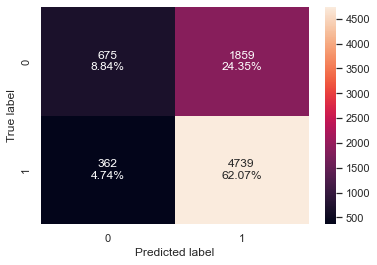

In [71]:
#Calculating different metrics
dtree_estimator_model_train_perf=model_performance_classification_sklearn(dtree_estimator,x_train,y_train)
print("Training performance:\n",dtree_estimator_model_train_perf)
dtree_estimator_model_test_perf=model_performance_classification_sklearn(dtree_estimator,x_test,y_test)
print("Testing performance:\n",dtree_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(dtree_estimator,x_test,y_test)

### Random Forest Classifier

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision       F1
0  0.720105  0.832974   0.767799  0.79906


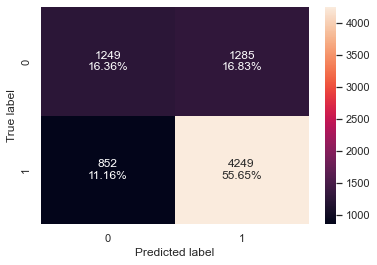

In [72]:
#Fitting the model
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(x_train,y_train)

#Calculating different metrics
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator,x_train,y_train)
print("Training performance:\n",rf_estimator_model_train_perf)
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator,x_test,y_test)
print("Testing performance:\n",rf_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_estimator,x_test,y_test)

This model performs better on all of the performance scores than the decision tree, but there's still significant overfitting.

#### Random Forest Hyperparameter Tuning

In [73]:
# Choose the type of classifier. 
rf_tuned = RandomForestClassifier(random_state=1,oob_score=False,bootstrap=True)

parameters = {  
                'max_depth': list(np.arange(5,20,5)),
                'max_features': ['sqrt','log2'],
                'min_samples_split': [5,7],
                'n_estimators': [10,15,20]}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_split=7,
                       n_estimators=20, random_state=1)

Training performance:
    Accuracy    Recall  Precision        F1
0   0.77066  0.909244    0.78264  0.841205
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.748396  0.888257   0.770316  0.825093


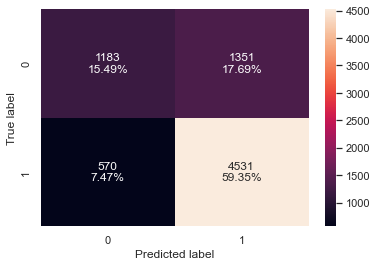

In [74]:
#Calculating different metrics
rf_tuned_model_train_perf=model_performance_classification_sklearn(rf_tuned,x_train,y_train)
print("Training performance:\n",rf_tuned_model_train_perf)
rf_tuned_model_test_perf=model_performance_classification_sklearn(rf_tuned,x_test,y_test)
print("Testing performance:\n",rf_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_tuned,x_test,y_test)

### Bagging Classifier

   Accuracy    Recall  Precision        F1
0  0.983775  0.984706   0.990951  0.987819
   Accuracy    Recall  Precision        F1
0  0.698232  0.777103   0.772559  0.774824


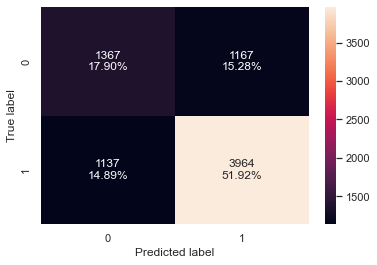

In [75]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(x_train,y_train)

#Calculating different metrics
bagging_classifier_model_train_perf=model_performance_classification_sklearn(bagging_classifier,x_train,y_train)
print(bagging_classifier_model_train_perf)
bagging_classifier_model_test_perf=model_performance_classification_sklearn(bagging_classifier,x_test,y_test)
print(bagging_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier,x_test,y_test)

As with the first two, there's still a lot of overfitting. Performance is similar to the random forest on the test data.

#### Bagging Hyperparameter Tuning

In [76]:
# Choose the type of classifier. 
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_samples': [0.7,0.9,1], 
              'max_features': [0.7,0.9,1],
              'n_estimators' : np.arange(60,100,10),
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(x_train, y_train)

BaggingClassifier(max_features=0.7, max_samples=0.7, n_estimators=70,
                  random_state=1)

   Accuracy    Recall  Precision        F1
0  0.993937  0.999832    0.99117  0.995482
   Accuracy    Recall  Precision        F1
0  0.722724  0.884728   0.746938  0.810015


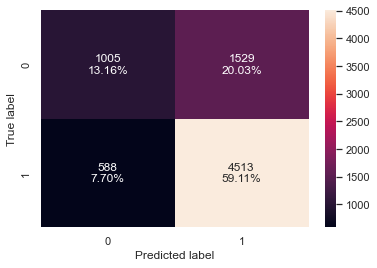

In [77]:
#Calculating different metrics
bagging_estimator_tuned_model_train_perf=model_performance_classification_sklearn(bagging_estimator_tuned,x_train,y_train)
print(bagging_estimator_tuned_model_train_perf)
bagging_estimator_tuned_model_test_perf=model_performance_classification_sklearn(bagging_estimator_tuned,x_test,y_test)
print(bagging_estimator_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_estimator_tuned,x_test,y_test)

### AdaBoost Classifier

   Accuracy   Recall  Precision        F1
0   0.73894  0.88916   0.760566  0.819851
   Accuracy    Recall  Precision        F1
0  0.733595  0.876887   0.760844  0.814754


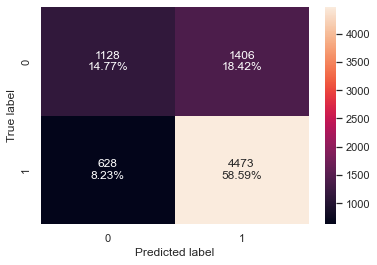

In [78]:
#Fitting the model
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(x_train,y_train)

#Calculating different metrics
ab_classifier_model_train_perf=model_performance_classification_sklearn(ab_classifier,x_train,y_train)
print(ab_classifier_model_train_perf)
ab_classifier_model_test_perf=model_performance_classification_sklearn(ab_classifier,x_test,y_test)
print(ab_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(ab_classifier,x_test,y_test)

This model looks to be have much better performance than the first 3. The performance scores on testing data remain high and may be slightly better than the others, especially on recall and the F1 score, and there appears to be very little if any overfitting occurring.

#### AdaBoost Hyperparameter Tuning

In [79]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    "base_estimator":[DecisionTreeClassifier(max_depth=1,class_weight="balanced", random_state=1),DecisionTreeClassifier(max_depth=2, class_weight="balanced", random_state=1),
                      DecisionTreeClassifier(max_depth=3, class_weight="balanced", random_state=1)],
    "n_estimators": np.arange(60,110,10),
    "learning_rate":np.arange(0.1,.5,0.1)
}

# Type of scoring used to compare parameter  combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=1,
                                                         random_state=1),
                   learning_rate=0.1, n_estimators=80, random_state=1)

   Accuracy   Recall  Precision        F1
0  0.717494  0.78042   0.793354  0.786834
   Accuracy   Recall  Precision        F1
0  0.717616  0.77279   0.798137  0.785259


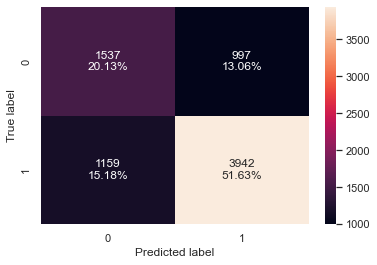

In [80]:
#Calculating different metrics
abc_tuned_model_train_perf=model_performance_classification_sklearn(abc_tuned,x_train,y_train)
print(abc_tuned_model_train_perf)
abc_tuned_model_test_perf=model_performance_classification_sklearn(abc_tuned,x_test,y_test)
print(abc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(abc_tuned,x_test,y_test)

### Gradient Boosting Classifier

Training performance:
    Accuracy    Recall  Precision       F1
0    0.7564  0.878992   0.782993  0.82822
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.745252  0.863948   0.778897  0.819221


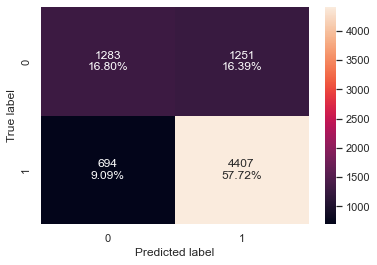

In [81]:
#Fitting the model
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(x_train,y_train)

#Calculating different metrics
gb_classifier_model_train_perf=model_performance_classification_sklearn(gb_classifier,x_train,y_train)
print("Training performance:\n",gb_classifier_model_train_perf)
gb_classifier_model_test_perf=model_performance_classification_sklearn(gb_classifier,x_test,y_test)
print("Testing performance:\n",gb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gb_classifier,x_test,y_test)

These results are very similar to the AdaBoost model, with very little overfitting occurring and a slightly higher F1 score due to increased precision.

#### Gradient Boosting Hyperparameter Tuning

In [82]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.8,0.9,1],
    "learning_rate":[0.1, 0.2]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(x_train, y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           max_features=0.9, n_estimators=150, random_state=1,
                           subsample=0.9)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.759937  0.878403   0.787005  0.830196
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.746955  0.865124   0.780095  0.820413


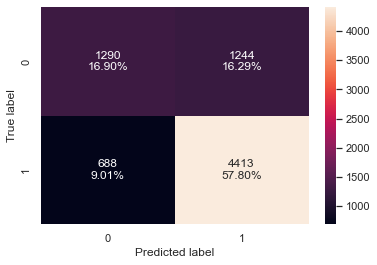

In [83]:
#Calculating different metrics
gbc_tuned_model_train_perf=model_performance_classification_sklearn(gbc_tuned,x_train,y_train)
print("Training performance:\n",gbc_tuned_model_train_perf)
gbc_tuned_model_test_perf=model_performance_classification_sklearn(gbc_tuned,x_test,y_test)
print("Testing performance:\n",gbc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gbc_tuned,x_test,y_test)

### XGBoost Classifier

Training performance:
    Accuracy    Recall  Precision        F1
0  0.836346  0.931261   0.840883  0.883767
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.732678  0.858851   0.768327  0.811071


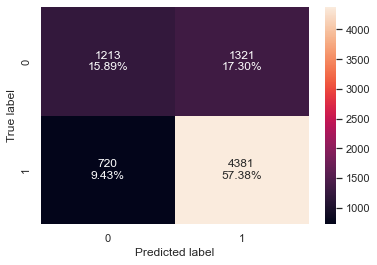

In [84]:
#Fitting the model
xgb_classifier = XGBClassifier(random_state=1, eval_metric='logloss')
xgb_classifier.fit(x_train,y_train)

#Calculating different metrics
xgb_classifier_model_train_perf=model_performance_classification_sklearn(xgb_classifier,x_train,y_train)
print("Training performance:\n",xgb_classifier_model_train_perf)
xgb_classifier_model_test_perf=model_performance_classification_sklearn(xgb_classifier,x_test,y_test)
print("Testing performance:\n",xgb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_classifier,x_test,y_test)

Performance on testing data looks similar to the AdaBoost and Gradient models, however there does appear to be more overfitting on this one.

#### XGBoost Hyperparameter Tuning

In [85]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": [150,250,50],
    "scale_pos_weight":[1,2],
    "subsample":[0.7,0.9],
    "learning_rate":[0.05, 0.1,0.2],
    "gamma":[3,5],
    "colsample_bytree":[0.7,0.9],
    "colsample_bylevel":[0.7,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=scorer,cv=5)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=3, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, ...)

Training performance:
    Accuracy  Recall  Precision        F1
0   0.76252    0.88   0.788911  0.831969
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.749443  0.866889   0.781825  0.822162


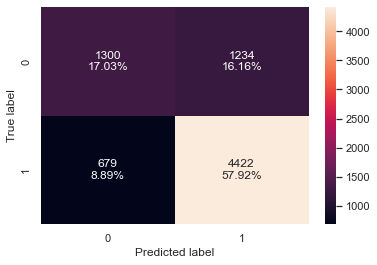

In [86]:
#Calculating different metrics
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned,x_train,y_train)
print("Training performance:\n",xgb_tuned_model_train_perf)
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned,x_test,y_test)
print("Testing performance:\n",xgb_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_tuned,x_test,y_test)

### Stacking Classifier

In [87]:
estimators = [('Random Forest',rf_tuned), ('Gradient Boosting',gbc_tuned), ('Decision Tree',dtree_estimator)]

final_estimator = xgb_tuned

stacking_classifier= StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_classifier.fit(x_train,y_train)

StackingClassifier(estimators=[('Random Forest',
                                RandomForestClassifier(max_depth=10,
                                                       max_features='sqrt',
                                                       min_samples_split=7,
                                                       n_estimators=20,
                                                       random_state=1)),
                               ('Gradient Boosting',
                                GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                                                           max_features=0.9,
                                                           n_estimators=150,
                                                           random_state=1,
                                                           subsample=0.9)),
                               ('Decision Tree',
                                DecisionTreeClassifier(cla...
                

Training performance:
    Accuracy   Recall  Precision        F1
0  0.762969  0.87437   0.792339  0.831336
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.745514  0.856891   0.782772  0.818156


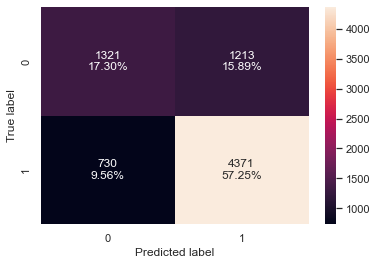

In [88]:
#Calculating different metrics
stacking_classifier_model_train_perf=model_performance_classification_sklearn(stacking_classifier,x_train,y_train)
print("Training performance:\n",stacking_classifier_model_train_perf)
stacking_classifier_model_test_perf=model_performance_classification_sklearn(stacking_classifier,x_test,y_test)
print("Testing performance:\n",stacking_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(stacking_classifier,x_test,y_test)

## Model Performance Comparison and Conclusions

In [89]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        d_tree_model_train_perf.T,
        dtree_estimator_model_train_perf.T,
        bagging_classifier_model_train_perf.T,
        bagging_estimator_tuned_model_train_perf.T,
        rf_estimator_model_train_perf.T,
        rf_tuned_model_train_perf.T,
        ab_classifier_model_train_perf.T,
        abc_tuned_model_train_perf.T,
        gb_classifier_model_train_perf.T,
        gbc_tuned_model_train_perf.T,
        xgb_classifier_model_train_perf.T,
        xgb_tuned_model_train_perf.T,
        stacking_classifier_model_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Tuned Decision Tree",
    "Bagging Classifier",
    "Tuned Bagging Classifier",
    "Random Forest",
    "Tuned Random Forest",
    "Adaboost Classifier",
    "Tuned Adaboost Classifier",
    "Gradient Boost Classifier",
    "Tuned Gradient Boost Classifier",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree,Tuned Decision Tree,Bagging Classifier,Tuned Bagging Classifier,Random Forest,Tuned Random Forest,Adaboost Classifier,Tuned Adaboost Classifier,Gradient Boost Classifier,Tuned Gradient Boost Classifier,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,1.0,0.711599,0.983775,0.993937,1.0,0.770660,0.738940,0.717494,0.756400,0.759937,0.836346,0.762520,0.762969
Recall,1.0,0.932605,0.984706,0.999832,1.0,0.909244,0.889160,0.780420,0.878992,0.878403,0.931261,0.880000,0.874370
Precision,1.0,0.719108,0.990951,0.991170,1.0,0.782640,0.760566,0.793354,0.782993,0.787005,0.840883,0.788911,0.792339
F1,1.0,0.812059,0.987819,0.995482,1.0,0.841205,0.819851,0.786834,0.828220,0.830196,0.883767,0.831969,0.831336


In [90]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        d_tree_model_test_perf.T,
        dtree_estimator_model_test_perf.T,
        bagging_classifier_model_test_perf.T,
        bagging_estimator_tuned_model_test_perf.T,
        rf_estimator_model_test_perf.T,
        rf_tuned_model_test_perf.T,
        ab_classifier_model_test_perf.T,
        abc_tuned_model_test_perf.T,
        gb_classifier_model_test_perf.T,
        gbc_tuned_model_test_perf.T,
        xgb_classifier_model_test_perf.T,
        xgb_tuned_model_test_perf.T,
        stacking_classifier_model_test_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Tuned Decision Tree",
    "Bagging Classifier",
    "Tuned Bagging Classifier",
    "Random Forest",
    "Tuned Random Forest",
    "Adaboost Classifier",
    "Tuned Adaboost Classifier",
    "Gradient Boost Classifier",
    "Tuned Gradient Boost Classifier",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier",
]
print("Testing performance comparison:")
models_train_comp_df

Testing performance comparison:


,Decision Tree,Tuned Decision Tree,Bagging Classifier,Tuned Bagging Classifier,Random Forest,Tuned Random Forest,Adaboost Classifier,Tuned Adaboost Classifier,Gradient Boost Classifier,Tuned Gradient Boost Classifier,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,0.665357,0.709103,0.698232,0.722724,0.720105,0.748396,0.733595,0.717616,0.745252,0.746955,0.732678,0.749443,0.745514
Recall,0.743972,0.929034,0.777103,0.884728,0.832974,0.888257,0.876887,0.772790,0.863948,0.865124,0.858851,0.866889,0.856891
Precision,0.752379,0.718248,0.772559,0.746938,0.767799,0.770316,0.760844,0.798137,0.778897,0.780095,0.768327,0.781825,0.782772
F1,0.748152,0.810155,0.774824,0.810015,0.799060,0.825093,0.814754,0.785259,0.819221,0.820413,0.811071,0.822162,0.818156


Looking at the testing performance comparison, the models that stand out are any with an F1 score above .81. This includes the following: Tuned Decision Tree, Tuned Bagging, Tuned Random Forst, AdaBoost Classifier, GB Classifier and Tuned GB Classifier, XGB and Tuned XGB, and Stacking. To narrow this down, I want to focus on models that perform better on recall than precision, because while both are important in this case, I believe it would be more advantageous for our model to have very strong recall, so we aren't proactively rejecting applicants who would have been approved, while it isn't as bad to fast track an applicant who we project to be approved but is ultimately rejected. Depending on resources this could be a poor assumption, but given the available info I believe it's the correct method.

Therefore, I'll narrow down that first list to any model that has above .88 Recall, which would include the Tuned Decision Tree, Tuned Bagging Classifier, and Tuned Random Forest. The Tuned Bagging Classifier has a significant amount of overfitting on the training data, so we can get rid of that option. Finally, though there appears to be a small amount of overfitting ocurring on the Tuned Random Forest model, it seems to be a relatively small amount, and the improvement in overall accuracy and F1 score vs the Tuned Decision Tree, while still maintaining nearly .9 recall, means this seems to be the best model available to us.

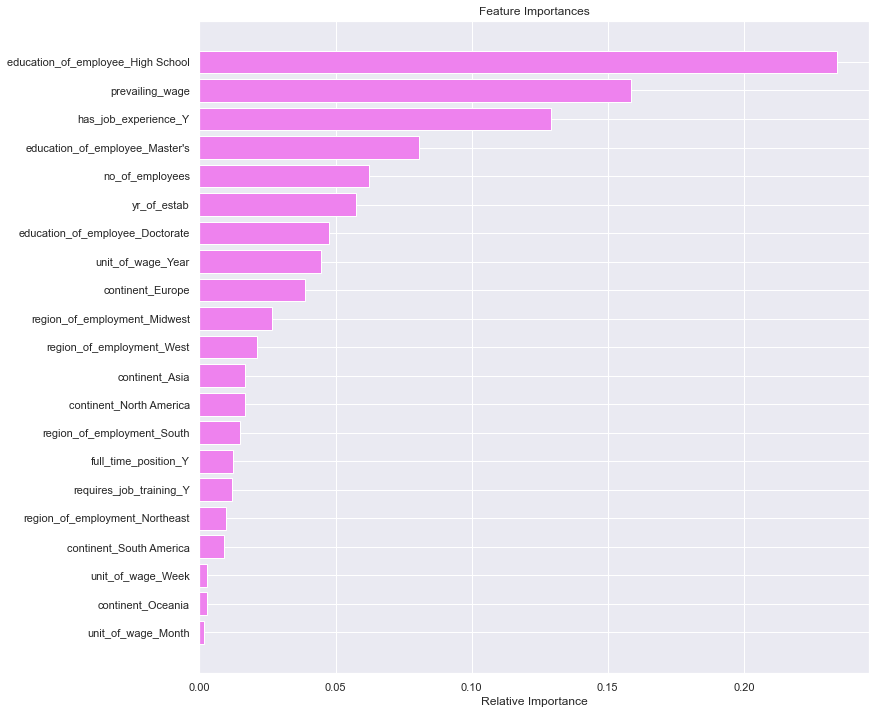

In [91]:
feature_names = x_train.columns
importances = rf_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Actionable Insights and Recommendations

For this project, I recommend using the tuned random forest model to predict whether an applicant will be approved for a visa or not and use the prediction to decide whether to pass along the application for review. Based on the performance of the model on our testing data, about 90% of applicants who would currently be approved will be passed through the process for manual review. Of the applicants that we pass through, about 76% will actually be approved and the other 24% will be denied. Without this model, in a pool of 100 applicants all 100 would be manually reviewed with 2/3 being approved and 1/3 being denied. By using our model to predict which should go through the manual review process, we will now only need to review 77 of the 100, and of those 77 we'll approve 77% of those applications. To summarize, we previously needed resources to review 100 applications, of which about 33 we spent time reviewing just to deny. Now, we only need resources to review 77 applications, and just 18 of those will be denied. This process will save significant time and resources and create a more efficient approval process.

For general insights, our model shows that the most important features of an application are the applicants level of education, especially if they don't hold a college level degree, as well as the prevailing wage and whether the applicant has job experience. Less important in our model are the region of employment and the continent that the applicant hails from. To me, this appears to make our process more equitable by basing our predictions on factors of qualification instead of location based information.